To build and train a Transformer-based model that classifies a given DNA sequence (e.g., "GATTACA...") as either a "promoter" (class 1) or a "non-promoter" (class 0). This is a binary classification task on biological sequence data using NLP architecture.

##### Import libraries

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tqdm.auto import tqdm

print("Libraries imported successfully.")

Libraries imported successfully.


##### Load Dataset

In [53]:
# Load the dataset
df = pd.read_csv('../dataset/dataset.csv')

# Let's take a quick look at the data
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Rename columns for easier access
# df = df.rename(columns={'Promoter/Non-Promoter': 'label', 'Sequence': 'sequence'})

print("\nClass Distribution:")
print(df['Label'].value_counts())

Dataset Shape: (22600, 3)

First 5 rows:
  Gene_Name         Label                                           Sequence
0     Clp_1  Non-Promoter  GCAATTCAAGTGTTGCTCTTGTGTAAGTGAAATTTTTGAAACTGGC...
1    Vsx2_1  Non-Promoter  CGGCTAGCGTGCGACAGAGACCGCCCCTGAATATTTACCGTTGCCG...
2     wgn_1  Non-Promoter  TCGATTGAGTTAGACCAACTAAAAACATTGGTCAACAAAAAACGCG...
3    Dlic_1  Non-Promoter  GCGATCAAAGTTCACAATGAGATTAAAGCGACATCTATGAGCAGCG...
4     CAP_2  Non-Promoter  TTGCCCATTTCTTAAGATTTATTTAAAGGAAAGACAGTACAGAAAT...

Class Distribution:
Label
Non-Promoter    11300
Promoter        11300
Name: count, dtype: int64


##### K-merization

In [54]:
def generate_kmers(sequence, k):
    """Generates a list of k-mers from a DNA sequence."""
    kmers = []
    num_kmers = len(sequence) - k + 1
    for i in range(num_kmers):
        kmer = sequence[i:i + k]
        kmers.append(kmer)
    return kmers

# Define the k-mer size
K_VALUE = 6

# Apply the function to our sequence column
# We'll join the k-mers into a single string separated by spaces, like a sentence.
df['kmers'] = df['Sequence'].apply(lambda seq: " ".join(generate_kmers(seq, K_VALUE)))

print("\nExample after K-merization:")
print(df[['Sequence', 'kmers']].head())


Example after K-merization:
                                            Sequence  \
0  GCAATTCAAGTGTTGCTCTTGTGTAAGTGAAATTTTTGAAACTGGC...   
1  CGGCTAGCGTGCGACAGAGACCGCCCCTGAATATTTACCGTTGCCG...   
2  TCGATTGAGTTAGACCAACTAAAAACATTGGTCAACAAAAAACGCG...   
3  GCGATCAAAGTTCACAATGAGATTAAAGCGACATCTATGAGCAGCG...   
4  TTGCCCATTTCTTAAGATTTATTTAAAGGAAAGACAGTACAGAAAT...   

                                               kmers  
0  GCAATT CAATTC AATTCA ATTCAA TTCAAG TCAAGT CAAG...  
1  CGGCTA GGCTAG GCTAGC CTAGCG TAGCGT AGCGTG GCGT...  
2  TCGATT CGATTG GATTGA ATTGAG TTGAGT TGAGTT GAGT...  
3  GCGATC CGATCA GATCAA ATCAAA TCAAAG CAAAGT AAAG...  
4  TTGCCC TGCCCA GCCCAT CCCATT CCATTT CATTTC ATTT...  


##### Label Encoding and Data Splitting

In [55]:
# Initialize the Label Encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
df['label_encoded'] = label_encoder.fit_transform(df['Label'])

print("\nLabels and their encoded values:")
print(df[['Label', 'label_encoded']].value_counts())


# Split the data into training and validation sets (80% train, 20% validation)
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,  # 30% for temp (will be split into val and test)
    random_state=42,
    stratify=df['label_encoded']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,  # Split the 30% into 15% val and 15% test
    random_state=42,
    stratify=temp_df['label_encoded']
)

print(f"\nTraining set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Labels and their encoded values:
Label         label_encoded
Non-Promoter  0                11300
Promoter      1                11300
Name: count, dtype: int64

Training set size: 15820
Validation set size: 3390
Test set size: 3390


##### Building the K-mer Vocabulary

In [56]:
# Create a set of all unique k-mers from the training data
all_kmers = set()
for text in train_df['kmers']:
    for kmer in text.split():
        all_kmers.add(kmer)

# Build the vocabulary mapping
# Reserve IDs for special tokens
kmer_to_id = {kmer: i+4 for i, kmer in enumerate(sorted(list(all_kmers)))}
kmer_to_id['[PAD]'] = 0  # Padding token
kmer_to_id['[UNK]'] = 1  # Unknown token
kmer_to_id['[CLS]'] = 2  # Classification token (start of sequence)
kmer_to_id['[SEP]'] = 3  # Separator token (end of sequence)

# Create the reverse mapping
id_to_kmer = {id: kmer for kmer, id in kmer_to_id.items()}

VOCAB_SIZE = len(kmer_to_id)
print(f"Vocabulary Size: {VOCAB_SIZE}")

Vocabulary Size: 4106


##### Creating a custom PyTorch dataset

In [57]:
class PromoterDataset(Dataset):
    def __init__(self, texts, labels, kmer_to_id, max_length):
        self.texts = texts
        self.labels = labels
        self.kmer_to_id = kmer_to_id
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # 1. Tokenize: Convert k-mers to integer IDs
        # Split sentence into k-mers and add CLS/SEP tokens
        kmer_list = text.split()
        token_ids = [self.kmer_to_id.get('[CLS]')]
        token_ids.extend([self.kmer_to_id.get(k, self.kmer_to_id['[UNK]']) for k in kmer_list])
        token_ids.append(self.kmer_to_id.get('[SEP]'))

        # 2. Pad or truncate the sequence
        if len(token_ids) < self.max_length:
            padding_len = self.max_length - len(token_ids)
            token_ids.extend([self.kmer_to_id['[PAD]']] * padding_len)
        else:
            token_ids = token_ids[:self.max_length-1] + [self.kmer_to_id.get('[SEP]')]

        # 3. Create attention mask
        attention_mask = [1 if id != self.kmer_to_id['[PAD]'] else 0 for id in token_ids]

        # 4. Convert to PyTorch tensors
        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

##### Instantiate Datasets and DataLoaders

In [58]:
# Set hyperparameters
MAX_LENGTH = 64  # Max k-mers per sequence (DNA length is 57, so ~52 kmers + special tokens)
BATCH_SIZE = 32

# Create Dataset instances
train_dataset = PromoterDataset(
    texts=train_df['kmers'].tolist(),
    labels=train_df['label_encoded'].tolist(),
    kmer_to_id=kmer_to_id,
    max_length=MAX_LENGTH
)

val_dataset = PromoterDataset(
    texts=val_df['kmers'].tolist(),
    labels=val_df['label_encoded'].tolist(),
    kmer_to_id=kmer_to_id,
    max_length=MAX_LENGTH
)

test_dataset = PromoterDataset(
    texts=test_df['kmers'].tolist(),
    labels=test_df['label_encoded'].tolist(),
    kmer_to_id=kmer_to_id,
    max_length=MAX_LENGTH
)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\nDataLoaders created successfully.")
# Let's check one batch to see the output shape
data_batch = next(iter(train_loader))
print("Batch shapes:", {k: v.shape for k, v in data_batch.items()})


DataLoaders created successfully.
Batch shapes: {'input_ids': torch.Size([32, 64]), 'attention_mask': torch.Size([32, 64]), 'labels': torch.Size([32])}


##### Configure and Instantiate the Model

In [59]:
from transformers import BertConfig, BertForSequenceClassification

# Define model configuration
config = BertConfig(
    vocab_size=VOCAB_SIZE,
    hidden_size=256,                    # Dimension of the encoder layers
    num_hidden_layers=4,                # Number of hidden layers
    num_attention_heads=4,              # Number of attention heads
    intermediate_size=1024,             # Dimension of the "feed-forward" layer
    max_position_embeddings=MAX_LENGTH,
    num_labels=2,                       # Binary classification (Promoter/Non-Promoter)
    hidden_dropout_prob=0.3,            # Default is 0.1
    attention_probs_dropout_prob=0.3    # Default is 0.1
)

# Instantiate the model with the new configuration
model = BertForSequenceClassification(config)

# Check the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel instantiated with {num_params:,} trainable parameters (BERT-base).")

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to device: {device}")


Model instantiated with 4,293,890 trainable parameters (BERT-base).
Model moved to device: cuda


##### Setup Optimizer and Scheduler

In [60]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

# Set hyperparameters
EPOCHS = 10
LEARNING_RATE = 2e-5 # A common starting point for fine-tuning BERT-like models

# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# Calculate total training steps for the scheduler
total_steps = len(train_loader) * EPOCHS

# Use 5-10% of total steps for warmup
# warmup_steps = int(total_steps * 0.05)

# Initialize the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, # Optional: Number of steps for a low learning rate warmup
    num_training_steps=total_steps
)

##### Training Function

In [61]:
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train() # Set the model to training mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(data_loader, desc="Training"):
        # Move batch to the correct device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Clear previously calculated gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        # Calculate accuracy
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_samples += labels.size(0)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions.double() / total_samples
    return avg_loss, accuracy

##### Evaluation Function

In [62]:
def eval_model(model, data_loader, device):
    model = model.eval() # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad(): # Disable gradient calculations
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_samples += labels.size(0)
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions.double() / total_samples
    return avg_loss, accuracy

##### Training Phase

In [63]:
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 20)

    train_loss, train_acc = train_epoch(
        model,
        train_loader,
        optimizer,
        device,
        scheduler
    )
    print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}')

    val_loss, val_acc = eval_model(
        model,
        val_loader,
        device
    )
    print(f'Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}')
    print()

    # Save the model if it has the best validation accuracy so far
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

print("Training complete!")
print(f"Best validation accuracy: {best_accuracy:.4f}")

Epoch 1/10
--------------------


Training: 100%|██████████| 495/495 [00:13<00:00, 36.03it/s]


Train loss: 0.6945, Train accuracy: 0.5045


Evaluating: 100%|██████████| 106/106 [00:01<00:00, 82.63it/s]


Validation loss: 0.6926, Validation accuracy: 0.5000

Epoch 2/10
--------------------


Training: 100%|██████████| 495/495 [00:13<00:00, 35.95it/s]


Train loss: 0.6930, Train accuracy: 0.5161


Evaluating: 100%|██████████| 106/106 [00:01<00:00, 93.19it/s]


Validation loss: 0.6890, Validation accuracy: 0.6024

Epoch 3/10
--------------------


Training: 100%|██████████| 495/495 [00:14<00:00, 35.17it/s]


Train loss: 0.6647, Train accuracy: 0.5946


Evaluating: 100%|██████████| 106/106 [00:01<00:00, 103.48it/s]


Validation loss: 0.6011, Validation accuracy: 0.6740

Epoch 4/10
--------------------


Training: 100%|██████████| 495/495 [00:13<00:00, 37.06it/s]


Train loss: 0.5955, Train accuracy: 0.6816


Evaluating: 100%|██████████| 106/106 [00:01<00:00, 84.08it/s]


Validation loss: 0.6074, Validation accuracy: 0.6720

Epoch 5/10
--------------------


Training: 100%|██████████| 495/495 [00:14<00:00, 34.10it/s]


Train loss: 0.5729, Train accuracy: 0.7047


Evaluating: 100%|██████████| 106/106 [00:01<00:00, 81.92it/s]


Validation loss: 0.6143, Validation accuracy: 0.6720

Epoch 6/10
--------------------


Training: 100%|██████████| 495/495 [00:13<00:00, 36.39it/s]


Train loss: 0.5596, Train accuracy: 0.7160


Evaluating: 100%|██████████| 106/106 [00:01<00:00, 99.97it/s]


Validation loss: 0.6015, Validation accuracy: 0.6791

Epoch 7/10
--------------------


Training: 100%|██████████| 495/495 [00:13<00:00, 36.63it/s]


Train loss: 0.5550, Train accuracy: 0.7209


Evaluating: 100%|██████████| 106/106 [00:01<00:00, 89.50it/s]


Validation loss: 0.6006, Validation accuracy: 0.6808

Epoch 8/10
--------------------


Training: 100%|██████████| 495/495 [00:14<00:00, 34.86it/s]


Train loss: 0.5470, Train accuracy: 0.7295


Evaluating: 100%|██████████| 106/106 [00:01<00:00, 105.71it/s]


Validation loss: 0.6058, Validation accuracy: 0.6805

Epoch 9/10
--------------------


Training: 100%|██████████| 495/495 [00:13<00:00, 36.48it/s]


Train loss: 0.5419, Train accuracy: 0.7326


Evaluating: 100%|██████████| 106/106 [00:01<00:00, 94.91it/s]


Validation loss: 0.6134, Validation accuracy: 0.6826

Epoch 10/10
--------------------


Training: 100%|██████████| 495/495 [00:13<00:00, 36.50it/s]


Train loss: 0.5390, Train accuracy: 0.7344


Evaluating: 100%|██████████| 106/106 [00:01<00:00, 76.23it/s]

Validation loss: 0.6111, Validation accuracy: 0.6817

Training complete!
Best validation accuracy: 0.6826


##### Inference on a single sequence

In [64]:
# Loading the best model
# Make sure you have the model architecture defined as before
config = BertConfig(
    vocab_size=VOCAB_SIZE,
    hidden_size=256,                        # Dimension of the encoder layers
    num_hidden_layers=4,                    # Number of hidden layers
    num_attention_heads=4,                  # Number of attention heads
    intermediate_size=1024,                 # Dimension of the "feed-forward" layer
    max_position_embeddings=MAX_LENGTH,
    num_labels=2,                           # Binary classification (Promoter/Non-Promoter)
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model = BertForSequenceClassification(config)

# Load the saved weights
model.load_state_dict(torch.load('best_model_state.bin'))

# Move model to the correct device and set to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print("Model loaded successfully and set to evaluation mode.")

Model loaded successfully and set to evaluation mode.


##### Prediction

In [65]:
def predict_sequence(sequence, model, kmer_to_id, max_length, device):
    # 1. K-merize the new sequence
    kmers = " ".join(generate_kmers(sequence, K_VALUE))

    # 2. Tokenize, add special tokens, and pad
    kmer_list = kmers.split()
    token_ids = [kmer_to_id['[CLS]']]
    token_ids.extend([kmer_to_id.get(k, kmer_to_id['[UNK]']) for k in kmer_list])
    token_ids.append(kmer_to_id['[SEP]'])

    if len(token_ids) < max_length:
        padding_len = max_length - len(token_ids)
        token_ids.extend([kmer_to_id['[PAD]']] * padding_len)
    else:
        token_ids = token_ids[:max_length-1] + [kmer_to_id['[SEP]']]

    # 3. Create attention mask
    attention_mask = [1 if id != kmer_to_id['[PAD]'] else 0 for id in token_ids]

    # 4. Convert to tensors and add batch dimension
    input_ids_tensor = torch.tensor([token_ids], dtype=torch.long).to(device)
    attention_mask_tensor = torch.tensor([attention_mask], dtype=torch.long).to(device)

    # 5. Make prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)

    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    confidence, predicted_class_id = torch.max(probabilities, dim=1)

    # 6. Decode the prediction
    predicted_label = label_encoder.inverse_transform([predicted_class_id.item()])[0]

    return predicted_label, confidence.item()

##### Test with New Sequences

In [66]:
# Example of a real human promoter sequence (from TATA-box)
promoter_example = "cgcgcccgcgccgcatatacgcgtatatacgcgtatacgcgtatacgcgtacgcgta"

# Example of a random, non-promoter-like sequence
non_promoter_example = "atcgatcgatcgatcgatcgatcgatcgatcgatcgatcgatcgatcgatcgatc"


label, confidence = predict_sequence(promoter_example, model, kmer_to_id, MAX_LENGTH, device)
print(f"Sequence: {promoter_example[:30]}...")
print(f"Predicted Label: {label}")
print(f"Confidence: {confidence:.4f}\n")


label, confidence = predict_sequence(non_promoter_example, model, kmer_to_id, MAX_LENGTH, device)
print(f"Sequence: {non_promoter_example[:30]}...")
print(f"Predicted Label: {label}")
print(f"Confidence: {confidence:.4f}")

Sequence: cgcgcccgcgccgcatatacgcgtatatac...
Predicted Label: Non-Promoter
Confidence: 0.8672

Sequence: atcgatcgatcgatcgatcgatcgatcgat...
Predicted Label: Non-Promoter
Confidence: 0.8747


##### Get Predictions for the Entire Test Set

In [67]:
def get_predictions(model, data_loader, device):
    model = model.eval()
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds)
            actual_labels.extend(labels)

    predictions = torch.stack(predictions).cpu()
    actual_labels = torch.stack(actual_labels).cpu()
    return predictions, actual_labels

# Assume you have a val_loader (or a test_loader)
y_pred, y_true = get_predictions(model, test_loader, device)

##### Generate Evaluation Reports

## Classification Report ##
              precision    recall  f1-score   support

Non-Promoter       0.70      0.67      0.68      1695
    Promoter       0.68      0.72      0.70      1695

    accuracy                           0.69      3390
   macro avg       0.69      0.69      0.69      3390
weighted avg       0.69      0.69      0.69      3390


## Confusion Matrix ##


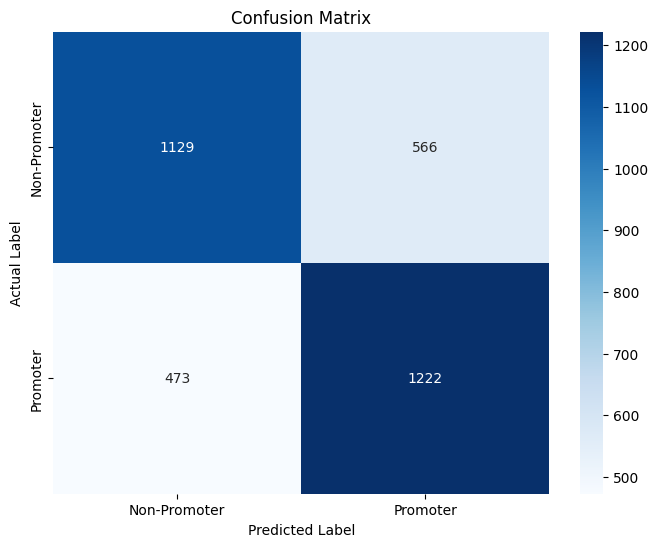

In [68]:
# Get class names from the label encoder
class_names = label_encoder.classes_

# Print Classification Report
print("## Classification Report ##")
print(classification_report(y_true, y_pred, target_names=class_names))


# Generate and Plot Confusion Matrix
print("\n## Confusion Matrix ##")
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [69]:
# Test accuracy
print(f"Test Accuracy: {(y_pred == y_true).sum().item() / len(y_true):.4f}")

Test Accuracy: 0.6935
